In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skp
import sklearn.feature_selection as skf
import sklearn.model_selection as skm
from scipy.stats import linregress
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import util
from imbalanced_regression.fds import FDS

In [2]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,False)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp

Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix


In [3]:
X_train,X_test,y_train,y_test,train_index,test_index = util.set_split(X_all_c,per_change,1,6/len(X_all_c))
X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                             X_train,train_index,X_test,test_index,pre_updrs_off)

In [4]:
# Weight initialization
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)

In [5]:
class ResNet(nn.Module):

    def __init__(self, xf, fds, bucket_num, bucket_start, start_update, start_smooth,
                 kernel, ks, sigma, momentum, targets, epoch):
        self.xf = xf
        self.targets = targets
        self.epoch = epoch
        super(ResNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.linear = nn.Linear(xf.shape[0],1)
        self.layer1 = nn.Linear(xf.shape[0],xf.shape[0]//2)
        self.layer2 = nn.Linear(xf.shape[0]//2,xf.shape[0]//4)
        self.layer3 = nn.Linear(xf.shape[0]//4,xf.shape[0]//8)
        self.layer4 = nn.Linear(xf.shape[0]//8,1)
        self.layer5 = nn.Linear(1,1)

        if fds:
            self.FDS = FDS(
                feature_dim=xf.shape[0], bucket_num=bucket_num, bucket_start=bucket_start,
                start_update=start_update, start_smooth=start_smooth, kernel=kernel, ks=ks, sigma=sigma, momentum=momentum
            )
        self.fds = fds
        self.start_smooth = start_smooth

    def forward(self,xf,targets=None):        
        epoch = self.epoch
        encoding = xf.view(xf.size(0), -1)

        encoding_s = encoding

        if self.training and self.fds:
            if epoch >= self.start_smooth:
                encoding_s = self.FDS.smooth(encoding_s, targets, epoch)

        xf = encoding_s.T      
        out = self.layer1(xf)
       
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.layer4(out)
        out = self.relu(out)
        y = self.layer5(out)
        return y, encoding

def resnet50(xf,**kwargs):
    return ResNet(xf,**kwargs)




In [9]:
def net(X_train,y_train,n_epochs,alpha,beta):   
    # Convert to 2D PyTorch tensors
    X_train, X_val, y_train, y_val = skm.train_test_split(X_train, y_train, test_size=0.33, random_state=1)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
    model = resnet50(X_val[0,:],fds=True, bucket_num=100, bucket_start=3,
                     start_update=0, start_smooth=1,
                     kernel='gaussian', ks=9, sigma=1, momentum=0.9, targets=y_train, epoch=0)
    model.apply(init_weights)
    # loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(),lr=alpha,momentum=beta)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=1e-1,patience=5,min_lr=1e-12)
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
    
    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []
    training_loss = []
    batch_loss = []
    for epoch in range(n_epochs):
        #if best_mse > 0.05:

            model.train()
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # take a batch
                    X_batch = X_train[start:start+batch_size,:]
                    y_batch = y_train[start:start+batch_size]
                    # forward pass
                    y_pred,X_batch_s = model(X_batch.T,y_batch)
                    loss = torch.sqrt(loss_fn(y_pred.ravel(), y_batch.ravel()))
                    batch_loss.append(loss.detach())
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # print progress
                    bar.set_postfix(mse=float(loss))
    
            # evaluate accuracy at end of each epoch
            model.eval()
            training_loss.append(np.mean(batch_loss))
            mses = []
            for k in np.arange(len(y_val)):
                y_pred, X_val_s = model(X_val[k,:].T,y_val[k].ravel())
                mses.append(torch.sqrt(loss_fn(y_pred.ravel(), y_val[k].ravel())).detach().numpy())
            mse = np.amax(np.asarray(mses))
            mse = float(mse)
            history.append(mse)
            if mse < best_mse:
                # if best_mse == np.inf: 
                #     if mse > 0.1:
                #         best_mse = mse
                #         print('Best MSE:',best_mse,'at learning rate',optimizer.param_groups[0]['lr'])
                #         best_weights = copy.deepcopy(model.state_dict())
                # else:
                best_mse = mse
                print('Best MSE:',best_mse,'at learning rate',np.format_float_scientific(optimizer.param_groups[0]['lr'],exp_digits=2))
                best_weights = copy.deepcopy(model.state_dict())
            scheduler.step(mse)
    
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))

    plt.plot(history)
    plt.plot(training_loss)
    
    plt.show()
    return model

In [10]:
results = np.zeros(per_change.shape)

Best MSE: 0.349435031414032 at learning rate 1.e-01
MSE: 0.35
RMSE: 0.59


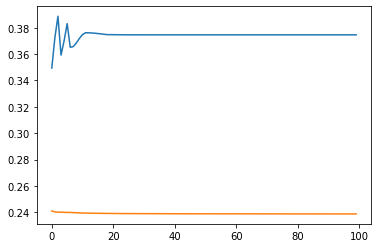

Model predicts 0.589958906173706 for case 67.0 with actual improvement 0.48333333333333334
Best MSE: 0.9853872656822205 at learning rate 1.e-01
Best MSE: 0.3925219178199768 at learning rate 1.e-01
Best MSE: 0.2612782120704651 at learning rate 1.e-01
Best MSE: 0.2603781819343567 at learning rate 1.e-01
MSE: 0.26
RMSE: 0.51


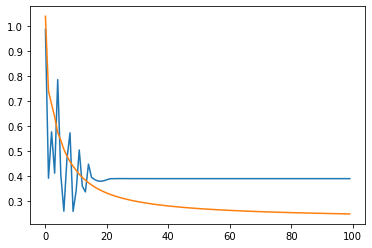

Model predicts 0.6790157556533813 for case 75.0 with actual improvement 0.967741935483871
Best MSE: 0.4671384394168854 at learning rate 1.e-01
Best MSE: 0.2600799798965454 at learning rate 1.e-01
MSE: 0.26
RMSE: 0.51


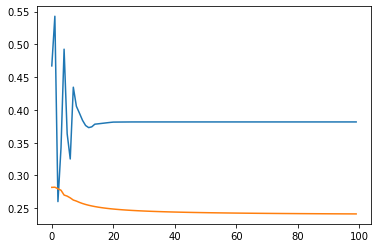

Model predicts 0.6793139576911926 for case 68.0 with actual improvement 0.7454545454545455
Best MSE: 0.692585289478302 at learning rate 1.e-01
Best MSE: 0.4949249029159546 at learning rate 1.e-01
Best MSE: 0.44619321823120117 at learning rate 1.e-01
Best MSE: 0.29828447103500366 at learning rate 1.e-01
Best MSE: 0.24642664194107056 at learning rate 1.e-01
Best MSE: 0.2314518690109253 at learning rate 1.e-01
MSE: 0.23
RMSE: 0.48


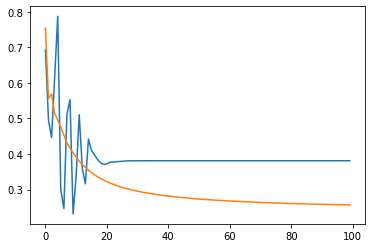

Model predicts 0.7079420685768127 for case 79.0 with actual improvement 0.6551724137931034
Best MSE: 0.3092561364173889 at learning rate 1.e-01
MSE: 0.31
RMSE: 0.56


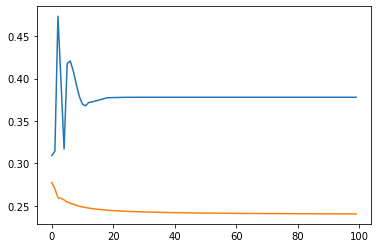

Model predicts 0.6301378011703491 for case 59.0 with actual improvement 0.7435897435897436
Best MSE: 0.7471361756324768 at learning rate 1.e-01
Best MSE: 0.5088088512420654 at learning rate 1.e-01
Best MSE: 0.3083322048187256 at learning rate 1.e-01
Best MSE: 0.28704971075057983 at learning rate 1.e-01
Best MSE: 0.21489518880844116 at learning rate 1.e-01
MSE: 0.21
RMSE: 0.46


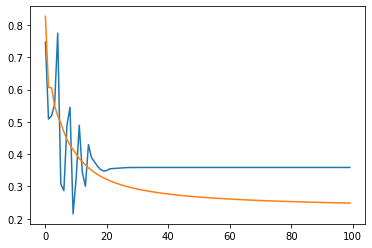

Model predicts 0.7244987487792969 for case 85.0 with actual improvement 0.14705882352941177
Best MSE: 0.3156874179840088 at learning rate 1.e-01
Best MSE: 0.27811533212661743 at learning rate 1.e-01
MSE: 0.28
RMSE: 0.53


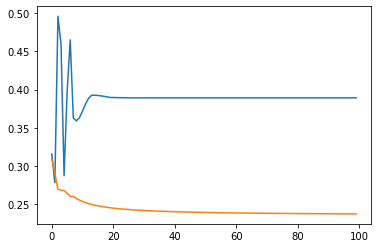

Model predicts 0.6612786054611206 for case 63.0 with actual improvement 0.8529411764705882
Best MSE: 0.4582256078720093 at learning rate 1.e-01
Best MSE: 0.2855638265609741 at learning rate 1.e-01
MSE: 0.29
RMSE: 0.53


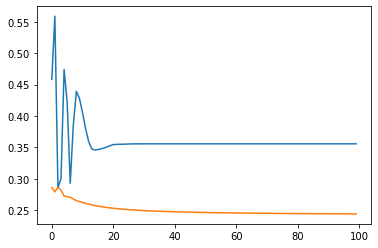

Model predicts 0.6538301110267639 for case 66.0 with actual improvement 0.53125
Best MSE: 0.9758623838424683 at learning rate 1.e-01
Best MSE: 0.3926241397857666 at learning rate 1.e-01
Best MSE: 0.3744577169418335 at learning rate 1.e-01
Best MSE: 0.256611168384552 at learning rate 1.e-01
MSE: 0.26
RMSE: 0.51


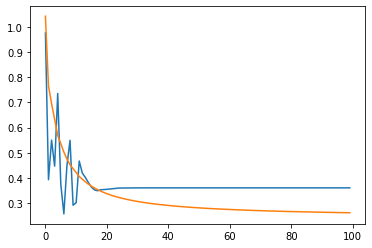

Model predicts 0.8121667504310608 for case 86.0 with actual improvement 0.5
Best MSE: 1.1119961738586426 at learning rate 1.e-01
Best MSE: 0.29818856716156006 at learning rate 1.e-01
Best MSE: 0.26186609268188477 at learning rate 1.e-01
MSE: 0.26
RMSE: 0.51


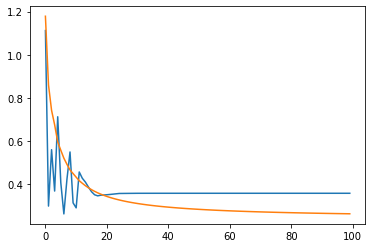

Model predicts 0.8174216747283936 for case 69.0 with actual improvement 0.4857142857142857
Best MSE: 1.0357555150985718 at learning rate 1.e-01
Best MSE: 0.354214608669281 at learning rate 1.e-01
Best MSE: 0.25491654872894287 at learning rate 1.e-01
MSE: 0.25
RMSE: 0.50


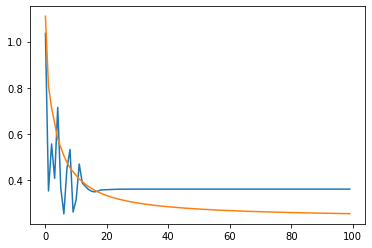

Model predicts 0.8104721307754517 for case 72.0 with actual improvement 0.2608695652173913
Best MSE: 0.9185814261436462 at learning rate 1.e-01
Best MSE: 0.42937755584716797 at learning rate 1.e-01
Best MSE: 0.38024330139160156 at learning rate 1.e-01
Best MSE: 0.28179067373275757 at learning rate 1.e-01
MSE: 0.28
RMSE: 0.53


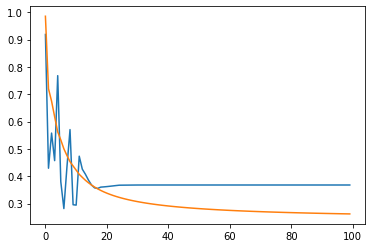

Model predicts 0.8373462557792664 for case 80.0 with actual improvement 0.5227272727272727
Best MSE: 0.44440463185310364 at learning rate 1.e-01
Best MSE: 0.26567286252975464 at learning rate 1.e-01
MSE: 0.27
RMSE: 0.52


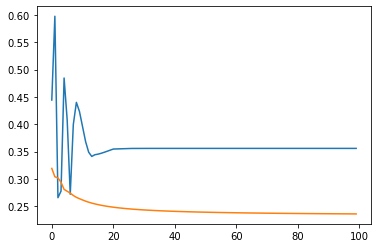

Model predicts 0.6737210750579834 for case 81.0 with actual improvement 0.19444444444444445
Best MSE: 0.8009867072105408 at learning rate 1.e-01
Best MSE: 0.49485206604003906 at learning rate 1.e-01
Best MSE: 0.37761133909225464 at learning rate 1.e-01
Best MSE: 0.3020052909851074 at learning rate 1.e-01
Best MSE: 0.28286248445510864 at learning rate 1.e-01
MSE: 0.28
RMSE: 0.53


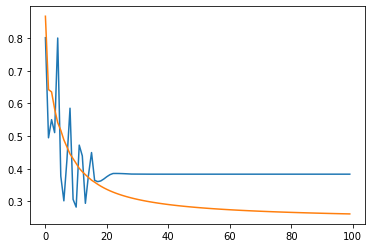

Model predicts 0.6565314531326294 for case 77.0 with actual improvement 0.559322033898305
Best MSE: 0.31805938482284546 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.56


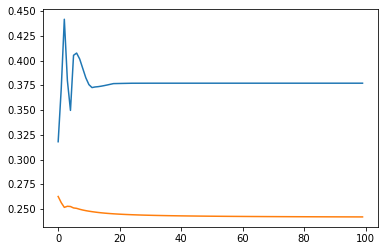

Model predicts 0.6213345527648926 for case 64.0 with actual improvement 0.6615384615384615
Best MSE: 0.3389630913734436 at learning rate 1.e-01
Best MSE: 0.21726924180984497 at learning rate 1.e-01
MSE: 0.22
RMSE: 0.47


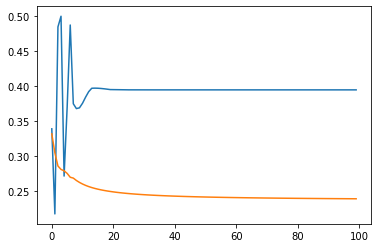

Model predicts 0.7221246957778931 for case 83.0 with actual improvement 0.8392857142857143
Best MSE: 0.33327949047088623 at learning rate 1.e-01
Best MSE: 0.22679150104522705 at learning rate 1.e-01
MSE: 0.23
RMSE: 0.48


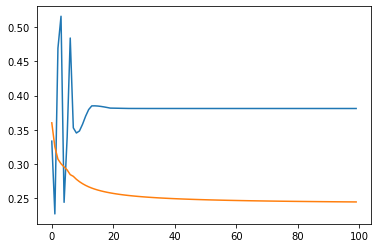

Model predicts 0.7823470830917358 for case 62.0 with actual improvement 0.46774193548387094
Best MSE: 0.4901261627674103 at learning rate 1.e-01
Best MSE: 0.4744594097137451 at learning rate 1.e-01
Best MSE: 0.22285723686218262 at learning rate 1.e-01
MSE: 0.22
RMSE: 0.47


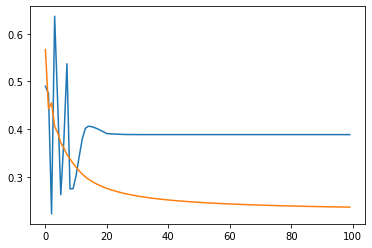

Model predicts 0.7784128189086914 for case 87.0 with actual improvement 0.08571428571428572
Best MSE: 0.3284379243850708 at learning rate 1.e-01
MSE: 0.33
RMSE: 0.57


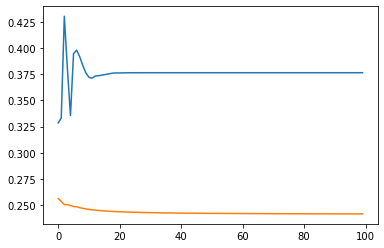

Model predicts 0.6109560132026672 for case 58.0 with actual improvement 0.5172413793103449
Best MSE: 0.6089240312576294 at learning rate 1.e-01
Best MSE: 0.511062502861023 at learning rate 1.e-01
Best MSE: 0.40487992763519287 at learning rate 1.e-01
Best MSE: 0.23276501893997192 at learning rate 1.e-01
Best MSE: 0.20348435640335083 at learning rate 1.e-01
MSE: 0.20
RMSE: 0.45


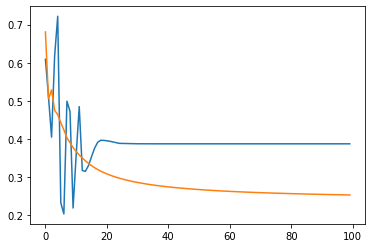

Model predicts 0.7590399384498596 for case 89.0 with actual improvement 0.358974358974359
Best MSE: 0.3859184980392456 at learning rate 1.e-01
Best MSE: 0.33245688676834106 at learning rate 1.e-01
MSE: 0.33
RMSE: 0.58


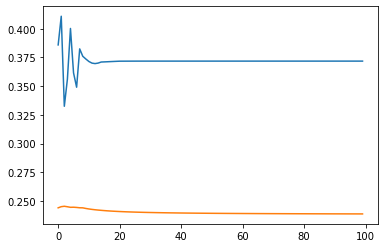

Model predicts 0.606937050819397 for case 78.0 with actual improvement 0.825
Best MSE: 0.3295517563819885 at learning rate 1.e-01
Best MSE: 0.32826462388038635 at learning rate 1.e-01
Best MSE: 0.3235549032688141 at learning rate 1.e-01
Best MSE: 0.29718834161758423 at learning rate 1.e-01
MSE: 0.30
RMSE: 0.55


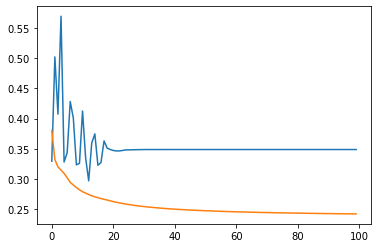

Model predicts 0.6422055959701538 for case 90.0 with actual improvement 0.3023255813953488
Best MSE: 0.34624263644218445 at learning rate 1.e-01
Best MSE: 0.3314143717288971 at learning rate 1.e-01
Best MSE: 0.32810455560684204 at learning rate 1.e-01
Best MSE: 0.32132184505462646 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


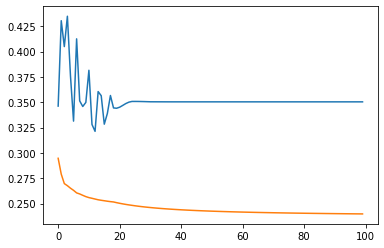

Model predicts 0.6180720925331116 for case 61.0 with actual improvement 0.8461538461538461
Best MSE: 1.032590627670288 at learning rate 1.e-01
Best MSE: 0.6283942461013794 at learning rate 1.e-01
Best MSE: 0.3491506576538086 at learning rate 1.e-01
Best MSE: 0.337225079536438 at learning rate 1.e-01
Best MSE: 0.3276655077934265 at learning rate 1.0000000000000002e-02
Best MSE: 0.32249099016189575 at learning rate 1.0000000000000002e-02
MSE: 0.32
RMSE: 0.57


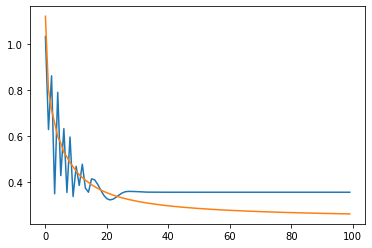

Model predicts 0.6169029474258423 for case 1.0 with actual improvement 0.8307692307692308
Best MSE: 0.35762643814086914 at learning rate 1.e-01
Best MSE: 0.34870287775993347 at learning rate 1.e-01
Best MSE: 0.33488354086875916 at learning rate 1.e-01
Best MSE: 0.3263065218925476 at learning rate 1.e-01
Best MSE: 0.3193012475967407 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


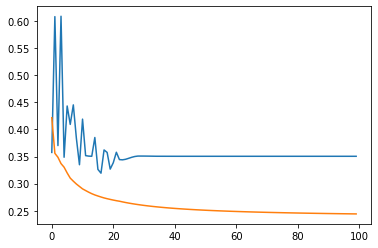

Model predicts 0.6200926899909973 for case 2.0 with actual improvement 0.9090909090909091
Best MSE: 1.0530002117156982 at learning rate 1.e-01
Best MSE: 0.6155253648757935 at learning rate 1.e-01
Best MSE: 0.3295024633407593 at learning rate 1.e-01
Best MSE: 0.3216381371021271 at learning rate 1.0000000000000002e-02
MSE: 0.32
RMSE: 0.57


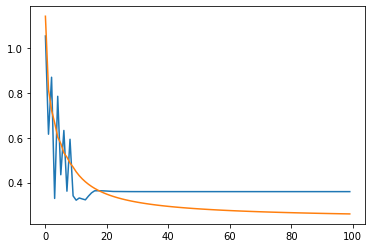

Model predicts 0.6239637136459351 for case 3.0 with actual improvement 0.5555555555555556
Best MSE: 1.3130401372909546 at learning rate 1.e-01
Best MSE: 0.47729846835136414 at learning rate 1.e-01
Best MSE: 0.47387757897377014 at learning rate 1.e-01
Best MSE: 0.4432983696460724 at learning rate 1.e-01
Best MSE: 0.42259907722473145 at learning rate 1.e-01
Best MSE: 0.3779571056365967 at learning rate 1.e-01
Best MSE: 0.36067458987236023 at learning rate 1.e-01
Best MSE: 0.32204070687294006 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


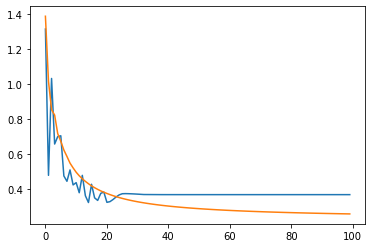

Model predicts 0.624366283416748 for case 6.0 with actual improvement 0.9523809523809523
Best MSE: 0.4488171339035034 at learning rate 1.e-01
Best MSE: 0.3831578195095062 at learning rate 1.e-01
Best MSE: 0.3667788505554199 at learning rate 1.e-01
Best MSE: 0.3348154127597809 at learning rate 1.e-01
Best MSE: 0.322623074054718 at learning rate 1.e-01
Best MSE: 0.3205810487270355 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


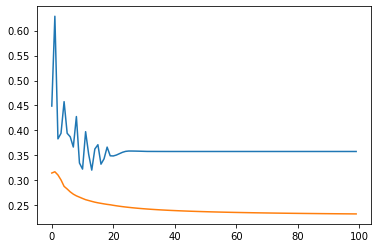

Model predicts 0.6229066252708435 for case 9.0 with actual improvement 0.8888888888888888
Best MSE: 0.35749977827072144 at learning rate 1.e-01
Best MSE: 0.32672128081321716 at learning rate 1.e-01
Best MSE: 0.3250402808189392 at learning rate 1.e-01
Best MSE: 0.32020145654678345 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


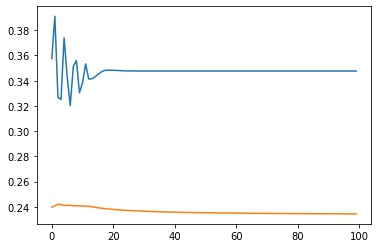

Model predicts 0.6191924810409546 for case 10.0 with actual improvement 0.5925925925925926
Best MSE: 0.35208001732826233 at learning rate 1.e-01
Best MSE: 0.35201364755630493 at learning rate 1.e-01
Best MSE: 0.33032259345054626 at learning rate 1.e-01
Best MSE: 0.32051882147789 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


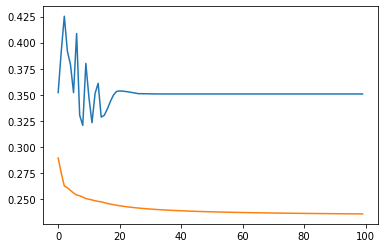

Model predicts 0.622844398021698 for case 11.0 with actual improvement 0.7368421052631579
Best MSE: 0.3584459125995636 at learning rate 1.e-01
Best MSE: 0.3572937846183777 at learning rate 1.e-01
Best MSE: 0.3561233580112457 at learning rate 1.e-01
Best MSE: 0.32705485820770264 at learning rate 1.e-01
Best MSE: 0.3210848569869995 at learning rate 1.e-01
Best MSE: 0.32098594307899475 at learning rate 1.e-01
Best MSE: 0.320919930934906 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


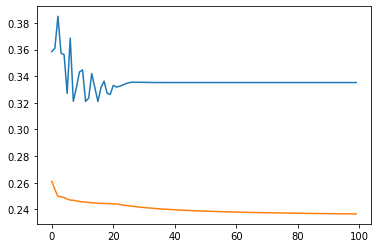

Model predicts 0.618474006652832 for case 12.0 with actual improvement 0.5
Best MSE: 1.2587952613830566 at learning rate 1.e-01
Best MSE: 0.5098295211791992 at learning rate 1.e-01
Best MSE: 0.5082184076309204 at learning rate 1.e-01
Best MSE: 0.4451124370098114 at learning rate 1.e-01
Best MSE: 0.41138750314712524 at learning rate 1.e-01
Best MSE: 0.3714117407798767 at learning rate 1.e-01
Best MSE: 0.3699009120464325 at learning rate 1.e-01
Best MSE: 0.3321398198604584 at learning rate 1.e-01
Best MSE: 0.32371190190315247 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


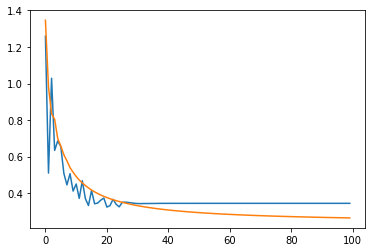

Model predicts 0.6260374784469604 for case 13.0 with actual improvement 0.7037037037037037
Best MSE: 1.124390721321106 at learning rate 1.e-01
Best MSE: 0.5762127637863159 at learning rate 1.e-01
Best MSE: 0.41581991314888 at learning rate 1.e-01
Best MSE: 0.32272255420684814 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


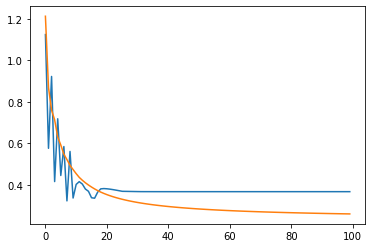

Model predicts 0.6166713833808899 for case 15.0 with actual improvement 0.6865671641791045
Best MSE: 0.5354308485984802 at learning rate 1.e-01
Best MSE: 0.5099343061447144 at learning rate 1.e-01
Best MSE: 0.3899782598018646 at learning rate 1.e-01
Best MSE: 0.3589203953742981 at learning rate 1.e-01
Best MSE: 0.3228241205215454 at learning rate 1.e-01
Best MSE: 0.32165732979774475 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


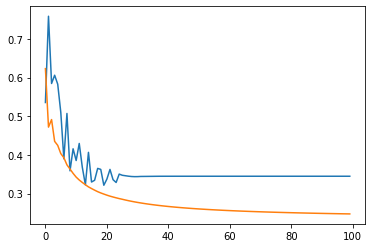

Model predicts 0.6239829063415527 for case 16.0 with actual improvement 0.8787878787878788
Best MSE: 0.538131594657898 at learning rate 1.e-01
Best MSE: 0.5056929588317871 at learning rate 1.e-01
Best MSE: 0.3946852385997772 at learning rate 1.e-01
Best MSE: 0.36357128620147705 at learning rate 1.e-01
Best MSE: 0.32137465476989746 at learning rate 1.e-01
Best MSE: 0.3191787600517273 at learning rate 1.0000000000000002e-02
MSE: 0.32
RMSE: 0.56


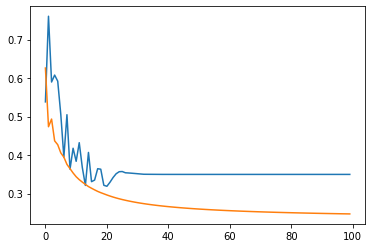

Model predicts 0.6202151775360107 for case 20.0 with actual improvement 0.6666666666666666
Best MSE: 0.37645161151885986 at learning rate 1.e-01
Best MSE: 0.35528573393821716 at learning rate 1.e-01
Best MSE: 0.32218801975250244 at learning rate 1.e-01
Best MSE: 0.3201030492782593 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


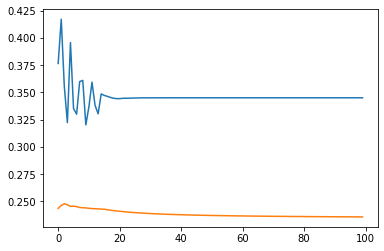

Model predicts 0.6192908883094788 for case 25.0 with actual improvement 0.7
Best MSE: 1.0901261568069458 at learning rate 1.e-01
Best MSE: 0.5934025049209595 at learning rate 1.e-01
Best MSE: 0.36670878529548645 at learning rate 1.e-01
Best MSE: 0.34465330839157104 at learning rate 1.e-01
Best MSE: 0.33636829257011414 at learning rate 1.0000000000000002e-02
MSE: 0.34
RMSE: 0.58


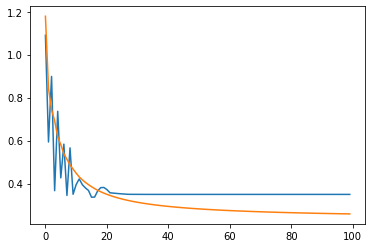

Model predicts 0.6386938691139221 for case 26.0 with actual improvement 0.8831168831168831
Best MSE: 0.34868788719177246 at learning rate 1.e-01
Best MSE: 0.33006900548934937 at learning rate 1.0000000000000002e-02
Best MSE: 0.3281836211681366 at learning rate 1.0000000000000002e-02
Best MSE: 0.3240886628627777 at learning rate 1.0000000000000002e-02
MSE: 0.32
RMSE: 0.57


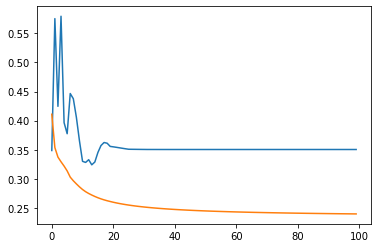

Model predicts 0.6264142394065857 for case 27.0 with actual improvement 0.7441860465116279
Best MSE: 0.6245360374450684 at learning rate 1.e-01
Best MSE: 0.5995688438415527 at learning rate 1.e-01
Best MSE: 0.32059547305107117 at learning rate 1.e-01
Best MSE: 0.31987127661705017 at learning rate 1.0000000000000002e-03
MSE: 0.32
RMSE: 0.57


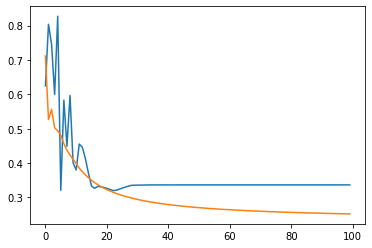

Model predicts 0.6221968531608582 for case 29.0 with actual improvement 0.8035714285714286
Best MSE: 0.7663336992263794 at learning rate 1.e-01
Best MSE: 0.4712517261505127 at learning rate 1.e-01
Best MSE: 0.39381587505340576 at learning rate 1.e-01
Best MSE: 0.3684214949607849 at learning rate 1.e-01
Best MSE: 0.35262784361839294 at learning rate 1.e-01
Best MSE: 0.349595308303833 at learning rate 1.e-01
Best MSE: 0.3259294331073761 at learning rate 1.e-01
Best MSE: 0.3242392838001251 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


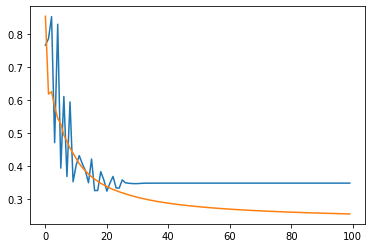

Model predicts 0.6265648603439331 for case 32.0 with actual improvement 0.6666666666666666
Best MSE: 0.9154961109161377 at learning rate 1.e-01
Best MSE: 0.699410080909729 at learning rate 1.e-01
Best MSE: 0.41532498598098755 at learning rate 1.e-01
Best MSE: 0.3881649971008301 at learning rate 1.e-01
Best MSE: 0.3700220286846161 at learning rate 1.e-01
Best MSE: 0.35918939113616943 at learning rate 1.e-01
Best MSE: 0.3291303217411041 at learning rate 1.e-01
Best MSE: 0.3194683790206909 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


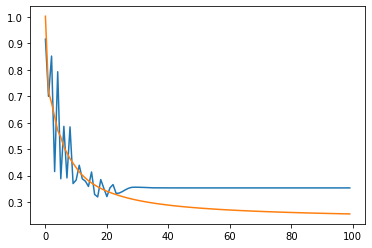

Model predicts 0.6199255585670471 for case 34.0 with actual improvement 0.691358024691358
Best MSE: 0.43032407760620117 at learning rate 1.e-01
Best MSE: 0.3907945454120636 at learning rate 1.e-01
Best MSE: 0.387356698513031 at learning rate 1.e-01
Best MSE: 0.3618432283401489 at learning rate 1.e-01
Best MSE: 0.3481570780277252 at learning rate 1.e-01
Best MSE: 0.3203287422657013 at learning rate 1.e-01
MSE: 0.32
RMSE: 0.57


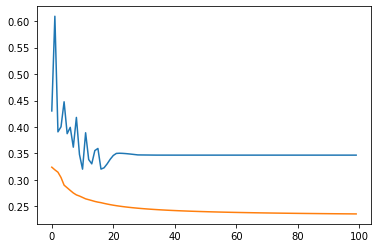

Model predicts 0.6226543188095093 for case 41.0 with actual improvement 0.42857142857142855
Best MSE: 0.4415348768234253 at learning rate 1.e-01
Best MSE: 0.4158004820346832 at learning rate 1.e-01
Best MSE: 0.35884326696395874 at learning rate 1.e-01
Best MSE: 0.33051598072052 at learning rate 1.e-01
Best MSE: 0.31879889965057373 at learning rate 1.0000000000000002e-02
MSE: 0.32
RMSE: 0.56


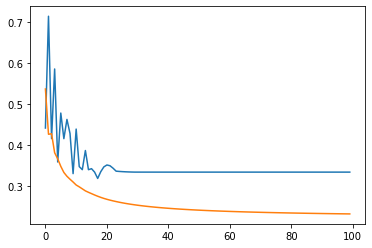

Model predicts 0.6205950379371643 for case 44.0 with actual improvement 0.1875
Best MSE: 0.3892267942428589 at learning rate 1.e-01
Best MSE: 0.3752322793006897 at learning rate 1.e-01
Best MSE: 0.3629907965660095 at learning rate 1.e-01
MSE: 0.36
RMSE: 0.60


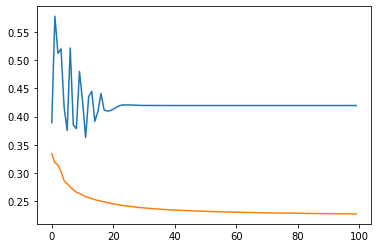

Model predicts 0.5504907965660095 for case 45.0 with actual improvement 0.9393939393939394
Best MSE: 0.7211446762084961 at learning rate 1.e-01
Best MSE: 0.39367926120758057 at learning rate 1.e-01
Best MSE: 0.366310715675354 at learning rate 1.e-01
MSE: 0.37
RMSE: 0.61


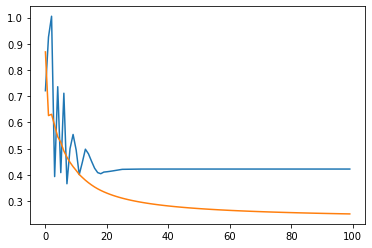

Model predicts 0.5427802205085754 for case 46.0 with actual improvement 0.5555555555555556
Best MSE: 0.38085001707077026 at learning rate 1.e-01
MSE: 0.38
RMSE: 0.62


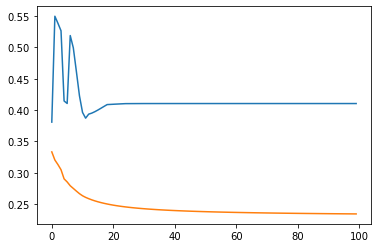

Model predicts 0.5282409191131592 for case 52.0 with actual improvement 0.6724137931034483
Best MSE: 0.4049544930458069 at learning rate 1.e-01
Best MSE: 0.39667683839797974 at learning rate 1.0000000000000002e-02
Best MSE: 0.3949759006500244 at learning rate 1.0000000000000002e-02
MSE: 0.39
RMSE: 0.63


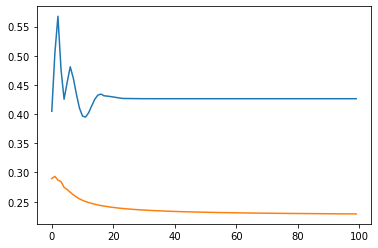

Model predicts 0.5824759006500244 for case 54.0 with actual improvement 0.873015873015873


In [11]:
for j in np.arange(len(subsc)):
    # Split the data
    Js = []
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    # Cross validation
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off)
    # Feature selection
    with np.errstate(divide='ignore', invalid='ignore'):
        sel = skf.SelectKBest(skf.r_regression,k=2000)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0.reshape([X_test_ss0.shape[0],
                                                X_test_ss0.shape[1]*X_test_ss0.shape[2]]))
    X0_ss = X0_ss0
    X_test_ss = X_test_ss0.reshape(X_test_ss0.shape[0],X_test_ss0.shape[1]*X_test_ss0.shape[2])
    tmodel = net(X0_ss,y_train,100,0.1,0.90)
    tmodel.eval()
    y_test,X_test_s = tmodel(torch.tensor(X_test_ss,dtype=torch.float32).T)#.reshape(X_test_ss.shape[0],X_test_ss.shape[1]*X_test_ss.shape[2]),dtype=torch.float32).T)
    results[j] = y_test
    # Output results
    print('Model predicts',str(results[j]),'for case',str(test_id),'with actual improvement',str(per_change[j]))



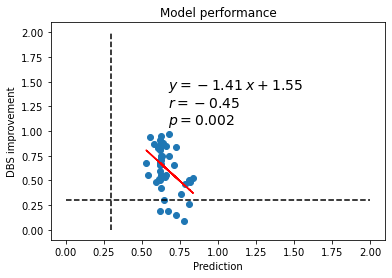

In [12]:
[fig,ax] = plt.subplots()
lr_prepost = linregress(results,per_change)
ax.scatter(results,per_change)
ax.plot(results,results*lr_prepost.slope+lr_prepost.intercept,'-r')
ax.set_title('Model performance')
ax.set_ylabel("DBS improvement")
ax.set_xlabel("Prediction")
text = f"$y={lr_prepost.slope:0.2f}\; x{lr_prepost.intercept:+0.2f}$\n$r = {lr_prepost.rvalue:0.2f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax.text(0.35, 0.75, text,transform=ax.transAxes,
    fontsize=14, verticalalignment='top')
ax.hlines(0.3,0,2,linestyle='dashed',color='black')
ax.vlines(0.3,0,2,linestyle='dashed',color='black')

In [13]:
results

array([0.58995891, 0.67901576, 0.67931396, 0.70794207, 0.6301378 ,
       0.72449875, 0.66127861, 0.65383011, 0.81216675, 0.81742167,
       0.81047213, 0.83734626, 0.67372108, 0.65653145, 0.62133455,
       0.7221247 , 0.78234708, 0.77841282, 0.61095601, 0.75903994,
       0.60693705, 0.6422056 , 0.61807209, 0.61690295, 0.62009269,
       0.62396371, 0.62436628, 0.62290663, 0.61919248, 0.6228444 ,
       0.61847401, 0.62603748, 0.61667138, 0.62398291, 0.62021518,
       0.61929089, 0.63869387, 0.62641424, 0.62219685, 0.62656486,
       0.61992556, 0.62265432, 0.62059504, 0.5504908 , 0.54278022,
       0.52824092, 0.5824759 ])

In [14]:
y_test

tensor([[0.5825]], grad_fn=<AddmmBackward0>)